# MNIST-Neural Network-Batch Normalization

In [1]:
# coding: utf-8
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append(os.pardir)
from common.mnist import *
from common.networks import *

## Multilayer Neural Network Model (Two Hidden Layers) and Learing/Validation

In [2]:
class N2_InitializerExtended:
    def __init__(self, params, params_size_list, use_batch_normalization):
        self.params = params
        self.params_size_list = params_size_list
        self.use_batch_normalization = use_batch_normalization

    def initialize_params(self):
        pass

    def get_params(self):
        return self.params
    
    def initialize_params(self):
        for idx in range(1, len(self.params_size_list)):
            self.params['W' + str(idx)] = np.random.randn(self.params_size_list[idx - 1], self.params_size_list[idx]) * 0.01
            self.params['b' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01
            if self.use_batch_normalization and idx < len(self.params_size_list) - 1:
                self.params['gamma' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01
                self.params['beta' + str(idx)] = np.random.randn(self.params_size_list[idx]) * 0.01

In [3]:
initializers = {
    'Zero': Zero_Initializer,
    'N1': N1_Initializer,
    'N2': N2_InitializerExtended, # We will use this new initializer
    'Xavier': Xavier_Initializer,
    'He': He_Initializer
}

class MultiLayerNetExtended(MultiLayerNet):
    def __init__(self, input_size, hidden_size_list, output_size, activation='ReLU', initializer='N2', 
                 use_batch_normalization=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        
        self.use_batch_normalization = use_batch_normalization
        
        # Weight Initialization
        self.params = {}
        self.weight_initialization(initializer)
        
        # Layering
        self.layers = OrderedDict()
        self.last_layer = None
        self.layering(activation)

        # Optimization Method
        self.optimizer = None
    
    def weight_initialization(self, initializer):
        params_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        initializer_obj = initializers[initializer](self.params, 
                                                    params_size_list, 
                                                    self.use_batch_normalization)
        initializer_obj.initialize_params();
        
    def layering(self, activation):
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])
            if self.use_batch_normalization:
                self.layers['Batch_Normalization' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], 
                                                                                   self.params['beta' + str(idx)])
            self.layers['Activation' + str(idx)] = activation_layers[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithCrossEntropyLoss()  

    def backpropagation_gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        din = 1
        din = self.last_layer.backward(din)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            din = layer.backward(din)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batch_normalization and idx <= self.hidden_layer_num:
                grads['gamma' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['Batch_Normalization' + str(idx)].dbeta
                
        return grads

In [4]:
data = mnist_data("/Users/yhhan/git/aiclass/0.Professor/data/MNIST_data/.")
(img_train, label_train), (img_validation, label_validation), (img_test, label_test) = data.load_mnist(flatten=True, normalize=True, one_hot_label=True)

input_size=784
hidden_layer1_size=128
hidden_layer2_size=128
output_size=10

num_epochs = 50
train_size = img_train.shape[0]
batch_size = 1000
learning_rate = 0.1

markers = {"No_Batch_Norm": "x", "Batch_Norm": "o"}

networks = {}
train_errors = {}
validation_errors = {}
test_accuracy_values = {}

for key in markers.keys():
    if key == 'No_Batch_Norm':
        networks[key] = MultiLayerNetExtended(input_size, 
                                [hidden_layer1_size, hidden_layer2_size], 
                                output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                use_batch_normalization=False)
    elif key == 'Batch_Norm':
        networks[key] = MultiLayerNetExtended(input_size, 
                                [hidden_layer1_size, hidden_layer2_size], 
                                output_size, 
                                activation='ReLU', 
                                initializer='N2',
                                use_batch_normalization=True)
    train_errors[key] = [] 
    validation_errors[key] = []
    test_accuracy_values[key] = []
    
epoch_list = []

num_batch = math.ceil(train_size / batch_size)

for i in range(num_epochs):
    epoch_list.append(i)
    for key in markers.keys():
        for k in range(num_batch):
            x_batch = img_train[k * batch_size : k * batch_size + batch_size]
            t_batch = label_train[k * batch_size : k * batch_size + batch_size]
            networks[key].learning(learning_rate, x_batch, t_batch, optimizer = 'SGD')

        train_loss = networks[key].loss(x_batch, t_batch)
        train_errors[key].append(train_loss)

        validation_loss = networks[key].loss(img_validation, label_validation)
        validation_errors[key].append(validation_loss)    

        test_accuracy = networks[key].accuracy(img_test, label_test)
        test_accuracy_values[key].append(test_accuracy)
        print("{0:13s} - Epoch: {1:5d}, Train Error: {2:7.5f}, Validation Error: {3:7.5f} - Test Accuracy: {4:7.5f}".format(
            key,
            i,
            train_loss,
            validation_loss,
            test_accuracy
        ))
    print()    

No_Batch_Norm - Epoch:     0, Train Error: 2.30153, Validation Error: 2.30125 - Test Accuracy: 0.11350
Batch_Norm    - Epoch:     0, Train Error: 2.30087, Validation Error: 2.30054 - Test Accuracy: 0.11350

No_Batch_Norm - Epoch:     1, Train Error: 2.30038, Validation Error: 2.30005 - Test Accuracy: 0.11350
Batch_Norm    - Epoch:     1, Train Error: 2.29366, Validation Error: 2.29300 - Test Accuracy: 0.11350

No_Batch_Norm - Epoch:     2, Train Error: 2.29761, Validation Error: 2.29732 - Test Accuracy: 0.11350
Batch_Norm    - Epoch:     2, Train Error: 2.22948, Validation Error: 2.22706 - Test Accuracy: 0.31820

No_Batch_Norm - Epoch:     3, Train Error: 2.28573, Validation Error: 2.28585 - Test Accuracy: 0.14740
Batch_Norm    - Epoch:     3, Train Error: 1.73149, Validation Error: 1.72122 - Test Accuracy: 0.48030

No_Batch_Norm - Epoch:     4, Train Error: 2.14781, Validation Error: 2.15334 - Test Accuracy: 0.24700
Batch_Norm    - Epoch:     4, Train Error: 0.92448, Validation Error:

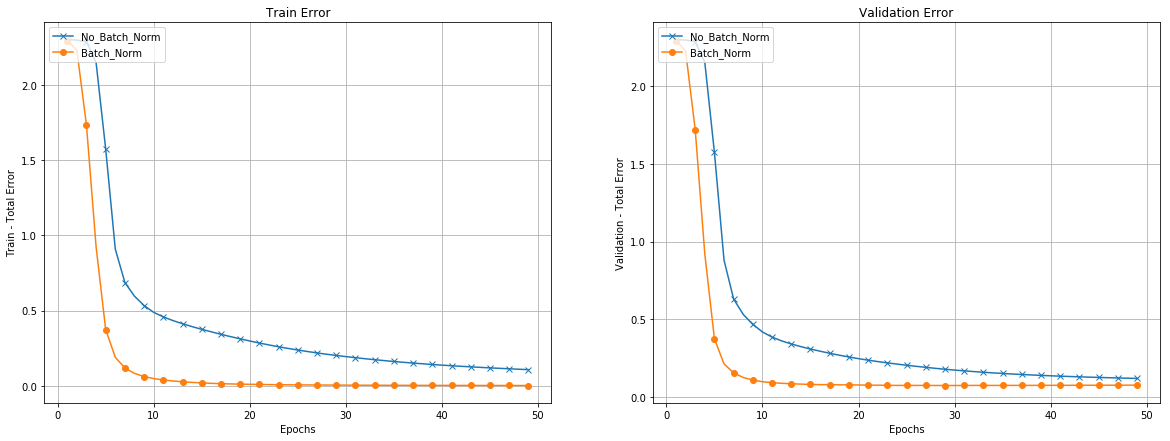

In [7]:
f, axarr = plt.subplots(1, 2, figsize=(20, 7))
for key in markers.keys():
    axarr[0].plot(epoch_list[1:], train_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[0].set_ylabel('Train - Total Error')
axarr[0].set_xlabel('Epochs')
axarr[0].grid(True)
axarr[0].set_title('Train Error')
axarr[0].legend(loc='upper left')

for key in markers.keys():
    axarr[1].plot(epoch_list[1:], validation_errors[key][1:], marker=markers[key], markevery=2, label=key)
axarr[1].set_ylabel('Validation - Total Error')
axarr[1].set_xlabel('Epochs')
axarr[1].grid(True)
axarr[1].set_title('Validation Error')
axarr[1].legend(loc='upper left')

f.subplots_adjust(hspace=0.3)

plt.show()

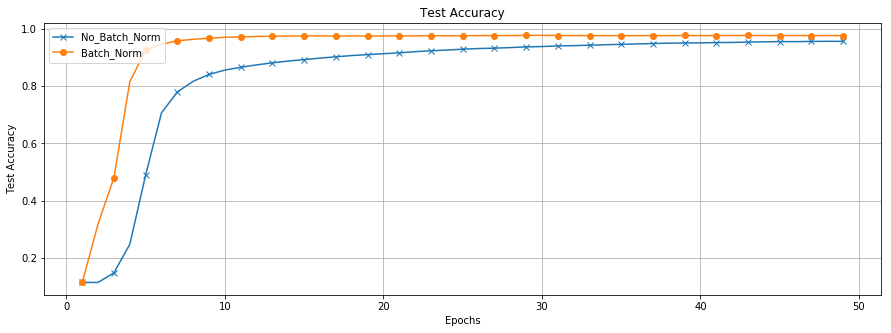

In [8]:
f, axarr = plt.subplots(1, 1, figsize=(15,5))
for key in markers.keys():
    axarr.plot(epoch_list[1:], test_accuracy_values[key][1:], marker=markers[key], markevery=2, label=key)
axarr.set_ylabel('Test Accuracy')
axarr.set_xlabel('Epochs')
axarr.grid(True)
axarr.set_title('Test Accuracy')
axarr.legend(loc='upper left')

f.subplots_adjust(hspace=0.3)
plt.show()